# Results

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Show the results of the evaluation
#data_path = "data/generated_texts.jsonl"

preds_path = "results/detection_logs.csv"

df_logs = pd.read_csv(preds_path)
# Show columns 
columns = df_logs.columns.tolist()

# == Display results ==

print("Columns in the dataset:", columns)
print( "Number of samples:", len(df_logs))

df_scores = df_logs[["score", "true_class", "predicted_class"] ]
# filtre les scores pour afficher que les true class = 0
df_human = df_scores[ df_scores["true_class"] == 0 ]
df_ai = df_scores[ df_scores["true_class"] == 1 ]
print(df_human)
print(df_ai)

# df_scores[""] = df_scores["true_class"].map({0: "Humain", 1: "IA"})

# plt.figure(figsize=(7, 5))
# sns.violinplot(
#     data=df,
#     x="label",
#     y="score",
#     palette=["#4C72B0", "#DD8452"],  # bleu / orange
#     inner="quartile",                # montre médiane et quartiles
#     cut=0
# )

# plt.title("Distribution des scores par type de texte", fontsize=13)
# plt.xlabel("")
# plt.ylabel("Score", fontsize=11)
# plt.grid(axis='y', linestyle='--', alpha=0.4)

# plt.tight_layout()
# plt.show()

Columns in the dataset: ['text', 'score', 'true_class', 'predicted_class']
Number of samples: 40
       score  true_class  predicted_class
0   1.133625           0                1
2   1.053922           0                1
4   1.135023           0                1
6   1.128397           0                1
8   1.125854           0                1
10  1.097753           0                1
12  1.129771           0                1
14  1.061515           0                1
16  1.090741           0                1
18  1.146110           0                1
20  1.133219           0                1
22  1.123431           0                1
24  1.053900           0                1
26  1.037607           0                1
28  1.104575           0                1
30  1.048131           0                1
32  1.063168           0                1
34  1.042228           0                1
36  1.014321           0                1
38  1.054471           0                1
       score  true_cl

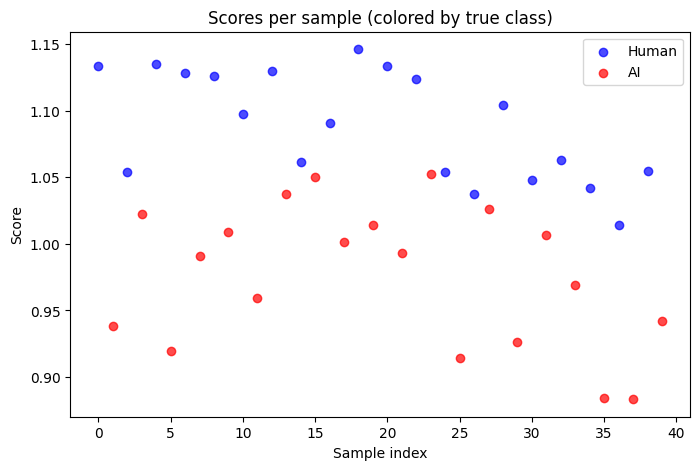

In [21]:
import matplotlib.pyplot as plt

# Séparer par classe
plt.figure(figsize=(8, 5))

plt.scatter(
    df_human.index,
    df_human.score,
    color="blue",
    label="Human",
    alpha=0.7
)

plt.scatter(
    df_ai.index,
    df_ai.score,
    color="red",
    label="AI",
    alpha=0.7
)

plt.ylabel("Score")
plt.xlabel("Sample index")
plt.title("Scores per sample (colored by true class)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple : ton DataFrame
# df = pd.DataFrame({
#     "score": [...],
#     "true_class": [...]  # 0 = humain, 1 = IA
# })

# Renommer les classes pour l’affichage
df["label"] = df["class"].map({0: "Humain", 1: "IA"})

plt.figure(figsize=(7, 5))
sns.violinplot(
    data=df,
    x="label",
    y="score",
    palette=["#4C72B0", "#DD8452"],  # bleu / orange
    inner="quartile",                # montre médiane et quartiles
    cut=0
)

plt.title("Distribution des scores par type de texte", fontsize=13)
plt.xlabel("")
plt.ylabel("Score", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined